In [2]:
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import osmnx as ox
import folium
import scipy

import seaborn as sns
sns.set_theme()

In [4]:
df = pd.read_csv('data/graf_polaczen.csv', header=0, low_memory = False)

In [5]:
df.head()

,Linia,Typ,Wariant,Przystanek startowy ID,Przystanek startowy nazwa,Przystanek końcowy ID,Przystanek końcowy nazwa,Czas przejazdu
0,0,Normalna tramwajowa,DWORZEC GŁÓWNY - ZOO,20267,DWORZEC GŁÓWNY,10269,Arkady (Capitol),3
1,0,Normalna tramwajowa,DWORZEC GŁÓWNY - ZOO,10269,Arkady (Capitol),10232,Renoma,3
2,0,Normalna tramwajowa,DWORZEC GŁÓWNY - ZOO,10232,Renoma,10054,Opera,1
3,0,Normalna tramwajowa,DWORZEC GŁÓWNY - ZOO,10054,Opera,10008,ŚWIDNICKA (Dom Europy),1
4,0,Normalna tramwajowa,DWORZEC GŁÓWNY - ZOO,10008,ŚWIDNICKA (Dom Europy),10011,Oławska,2


# Wizualizacje

In [88]:
G = nx.DiGraph()

for _, row in df.iterrows():
    start = row['Przystanek startowy nazwa']
    end = row['Przystanek końcowy nazwa']
    time = row['Czas przejazdu']
    line = row['Linia']
    typ = row['Typ']
    
    if 'autobusowa' in typ:
        transport_type = 'autobus'
    else:
        transport_type = 'tramwaj'

    if G.has_edge(start, end):
        G[start][end]['count'] += 1
        G[start][end]['length'] = (G[start][end]['length'] * G[start][end]['count'] + time) / (G[start][end]['count'] + 1)
        G[start][end]['lines'].add(line)
        G[start][end]['transport'] = transport_type
    else:
        G.add_edge(start, end, count=1, length=time, lines={line}, transport=transport_type)

print(f"Graf ma {G.number_of_nodes()} węzłów i {G.number_of_edges()} krawędzi.")

Graf ma 958 węzłów i 8507 krawędzi.


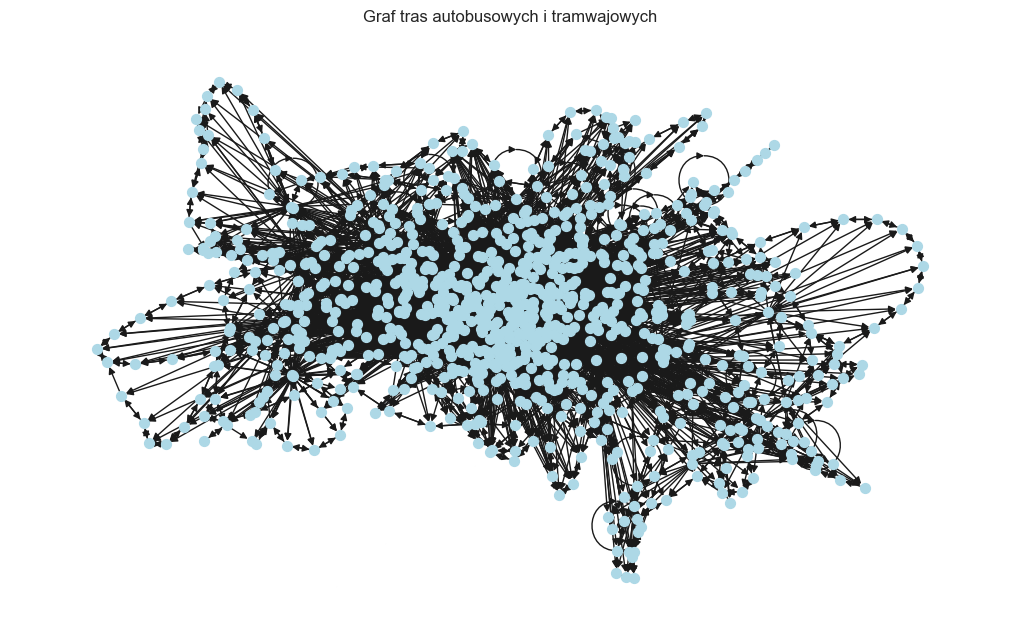

In [89]:
pos = nx.spring_layout(G) 
edge_labels = nx.get_edge_attributes(G, 'Weight')  

plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_size=50, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Graf tras autobusowych i tramwajowych")
plt.show()

In [39]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

G_autobusy = nx.DiGraph()
G_tramwaje = nx.DiGraph()

for _, row in df.iterrows():
    start = row['Przystanek startowy nazwa']
    end = row['Przystanek końcowy nazwa']
    time = row['Czas przejazdu']
    line = row['Linia']
    typ = row['Typ']

    if 'autobusowa' in typ:
        G_autobusy.add_edge(start, end, length=time, lines={line})
    else:
        G_tramwaje.add_edge(start, end, length=time, lines={line})

def draw_graph(G, title, node_color, edge_color_map):
    pos = nx.kamada_kawai_layout(G) 
    edge_colors = ['gray' for _ in G.edges()]
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_size=50, node_color=node_color, font_size=10, font_weight='bold', edge_color=edge_colors)
    
    
    plt.title(title)
    plt.show()

edge_color_map = {
    'autobusowa': 'red', 
    'tramwaj': 'blue'
}

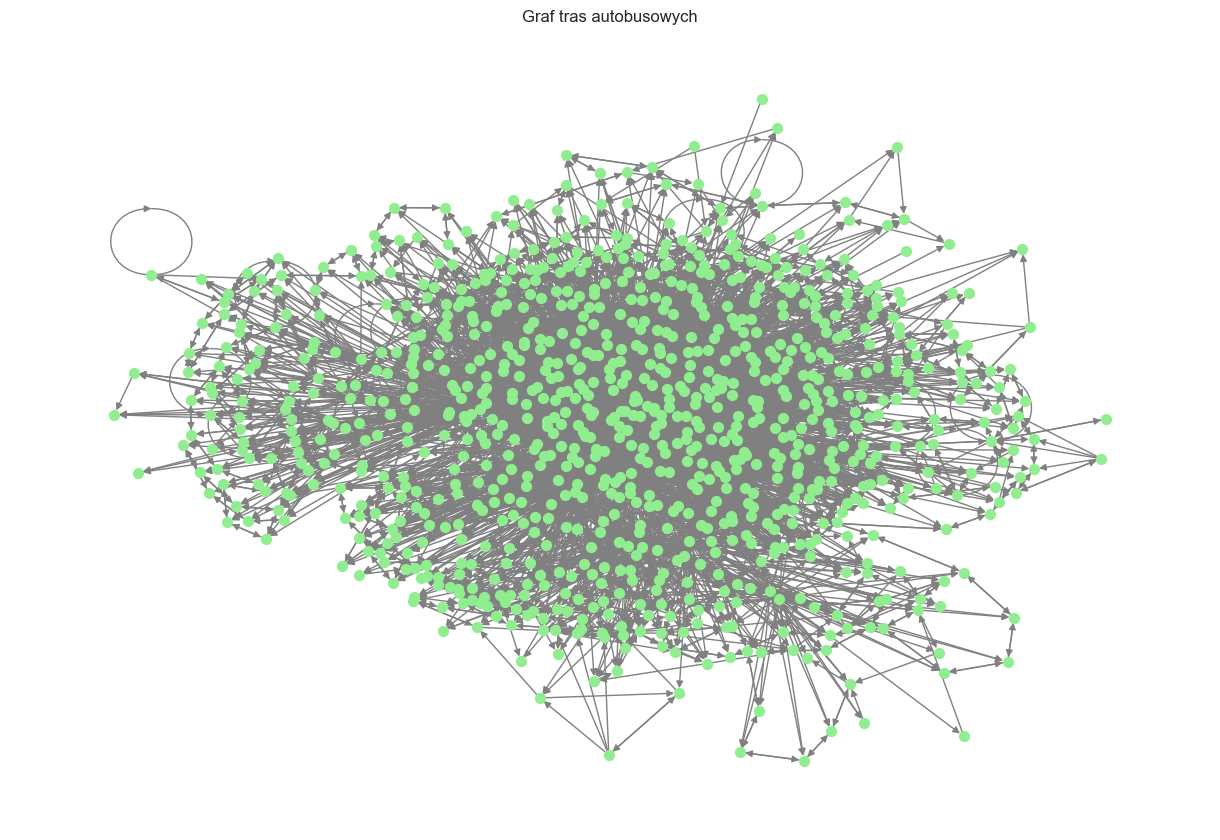

In [ ]:
draw_graph(G_autobusy, "Graf tras autobusowych", 'lightgreen', edge_color_map)

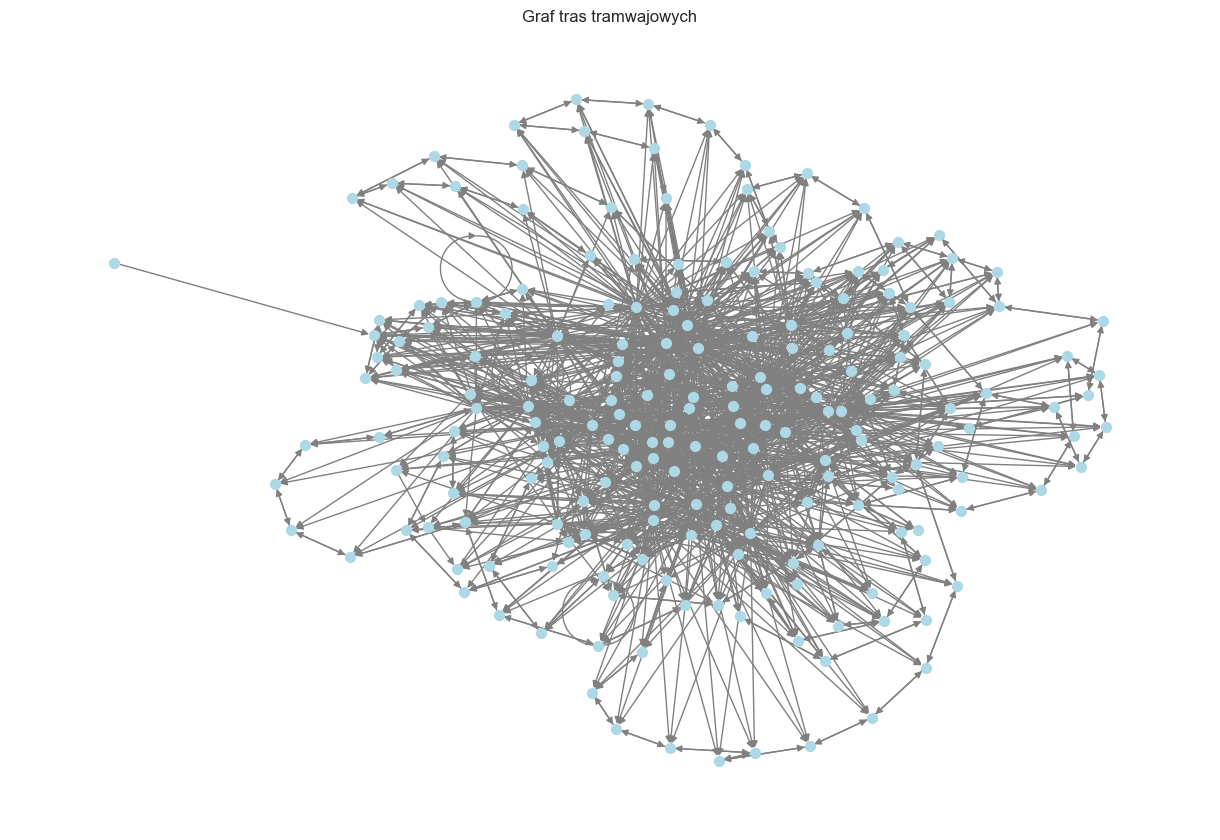

In [41]:
# Rysowanie grafu dla tramwajów
draw_graph(G_tramwaje, "Graf tras tramwajowych", 'lightblue', edge_color_map)

In [93]:
min_connections_node = min(G.nodes(), key=lambda node: G.degree(node))

print(f"Przystanek z najmniejszą liczbą połączeń: {min_connections_node}")

Przystanek z najmniejszą liczbą połączeń: GRABISZYNEK


# Analiza grafu

In [94]:
autobus_times = [data['length'] for u, v, data in G.edges(data=True) if data['transport'] == 'autobus']
tramwaj_times = [data['length'] for u, v, data in G.edges(data=True) if data['transport'] == 'tramwaj']
import numpy as np
print("Średni czas przejazdu dla autobusów:", abs(np.mean(autobus_times)))
print("Średni czas przejazdu dla tramwajów:", abs(np.mean(tramwaj_times)))

Średni czas przejazdu dla autobusów: 23.620562448295612
Średni czas przejazdu dla tramwajów: 25.723303877167346


**Najdłuższa trasa**

Miara, która pomaga zrozumieć, jak daleko mogą podróżować pasażerowie, aby dotrzeć z jednego punktu sieci do drugiego.

Im większa średnica, tym dłuższe mogą być podróże pasażerów między różnymi obszarami miasta, co może wpływać na czas podróży oraz komfort podróżowania.

In [90]:
components = list(nx.strongly_connected_components(G))

for component in components:
    if len(component) > 1:  
        subgraph = G.subgraph(component)
        try:
            diameter = nx.diameter(subgraph)
            print(f"Średnica dla składnika: {diameter}")
        except nx.NetworkXError as e:
            print(f"Błąd przy obliczaniu średnicy dla składnika: {e}")
    else:
        print(f"Składnik o jednej krawędzi, średnica nie jest definiowana: {component}")

Średnica dla składnika: 17
Składnik o jednej krawędzi, średnica nie jest definiowana: {'GRABISZYNEK'}
Składnik o jednej krawędzi, średnica nie jest definiowana: {'C.H. Aleja Bielany'}
Składnik o jednej krawędzi, średnica nie jest definiowana: {'Sucha'}
Składnik o jednej krawędzi, średnica nie jest definiowana: {'Żórawina - kościół Św. Trójcy'}
Składnik o jednej krawędzi, średnica nie jest definiowana: {'Rzeplin - pętla'}


**Rozkład najkrótszych ścieżek**

Sieci o krótkich ścieżkach i wąskim rozkładzie mogą ułatwiać szybkie podróże między różnymi obszarami, podczas gdy sieci z długimi ścieżkami lub szerokim rozkładem mogą być bardziej wydłużone i mniej efektywne w komunikacji.

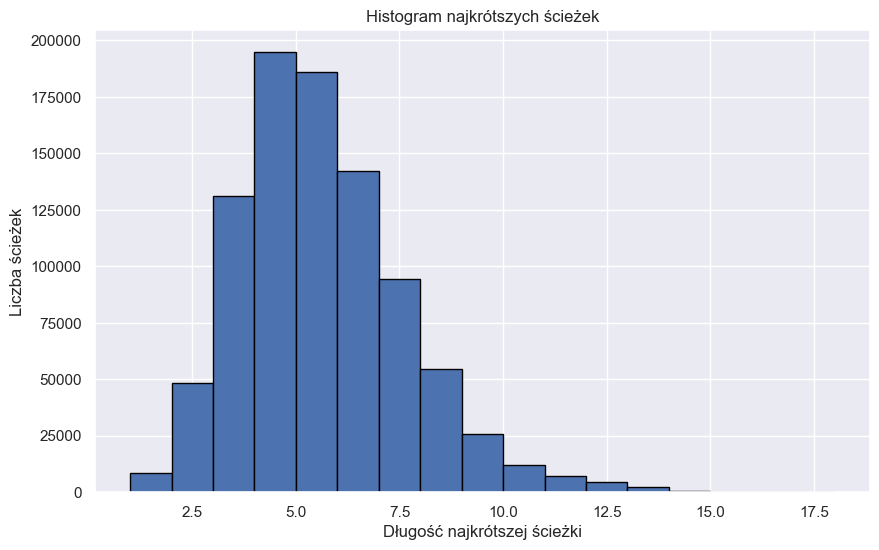

In [91]:
shortest_path_lengths = []

for source in G.nodes():
    lengths = nx.single_source_shortest_path_length(G, source)
    for target, length in lengths.items():
        if source != target:  
            shortest_path_lengths.append(length)

plt.figure(figsize=(10, 6))
plt.hist(shortest_path_lengths, bins=range(1, max(shortest_path_lengths) + 2), edgecolor='black')
plt.title('Histogram najkrótszych ścieżek')
plt.xlabel('Długość najkrótszej ścieżki')
plt.ylabel('Liczba ścieżek')
plt.show()

**Krytyczność przystanku**

Przewodnictwo (Betweenness centrality) określa pozycję węzła na podstawie liczby najkrótszych ścieżek przechodzących przez ten węzeł w stosunku do liczby wszystkich najkrótszych ścieżek.

Wierzchołki o wysokiej wartości betweenness centrality są kluczowe dla połączeń między różnymi częściami sieci i mogą mieć duży wpływ na wydajność oraz płynność ruchu.

In [95]:
betweenness = nx.betweenness_centrality(G)

top_10_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("10 przystanków o największym przewodnictwie (betweenness centrality):")
for stop, centrality in top_10_betweenness:
    print(f"{stop}: {centrality}")

10 przystanków o największym przewodnictwie (betweenness centrality):
LEŚNICA: 0.18210049810414025
GALERIA DOMINIKAŃSKA: 0.15074787371853815
KROMERA: 0.11060933472441939
KRZYKI: 0.08681324262454665
PL. GRUNWALDZKI: 0.08241515232286108
Wrocław Nowy Dwór (P+R): 0.07574510274364984
SĘPOLNO: 0.07168791585521055
Kwiska: 0.0689335565280484
OPORÓW: 0.06731602040587549
DWORZEC AUTOBUSOWY: 0.06320938479154882


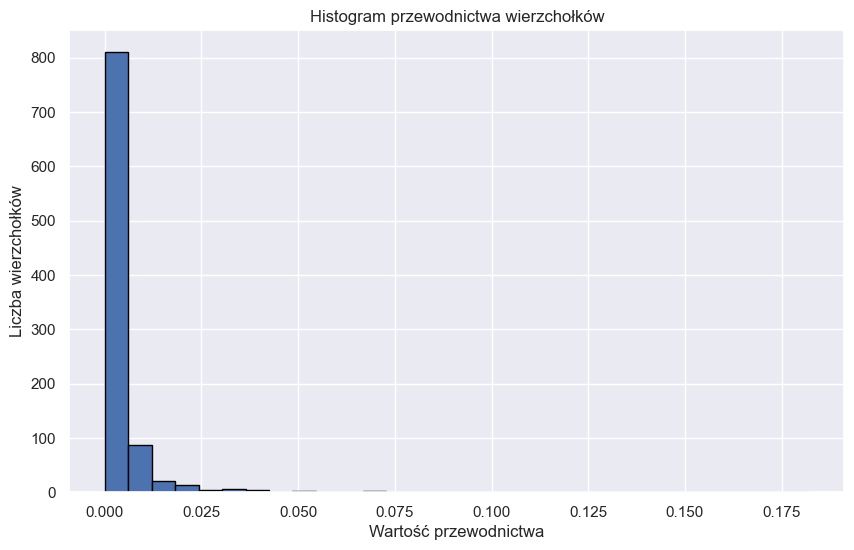

In [96]:
plt.figure(figsize=(10, 6))
plt.hist(list(betweenness.values()), bins=30, edgecolor='black')  
plt.title('Histogram przewodnictwa wierzchołków')
plt.xlabel('Wartość przewodnictwa')
plt.ylabel('Liczba wierzchołków')
plt.show()

**Najważniejsze węzły komunikacyjne**

Przystanki o wysokim stopniu mogą być kluczowe dla obsługi dużej liczby linii autobusowych lub tramwajowych, co może sugerować, że są to ważne węzły transferowe.

In [97]:
degree = list(nx.degree(G))

best_degree = [i[0] for i in sorted(degree, key=lambda x: x[1], reverse=True)[:20]]

degree_val = [x[1] for x in degree]

print("20 przystanków o największym stopniu:")
for stop in best_degree:
    print(stop)

20 przystanków o największym stopniu:
KRZYKI
LEŚNICA
SĘPOLNO
Wrocław Nowy Dwór (P+R)
GALERIA DOMINIKAŃSKA
OPORÓW
DWORZEC AUTOBUSOWY
KROMERA
Zajezdnia Obornicka
PRACZE ODRZAŃSKIE
PL. GRUNWALDZKI
TARNOGAJ
DWORZEC GŁÓWNY
KOZANÓW
GIEŁDOWA (Centrum Hurtu)
ZWYCIĘSKA
KMINKOWA
KSIĘŻE WIELKIE
BISKUPIN
TARCZYŃSKI ARENA (Królewiecka)


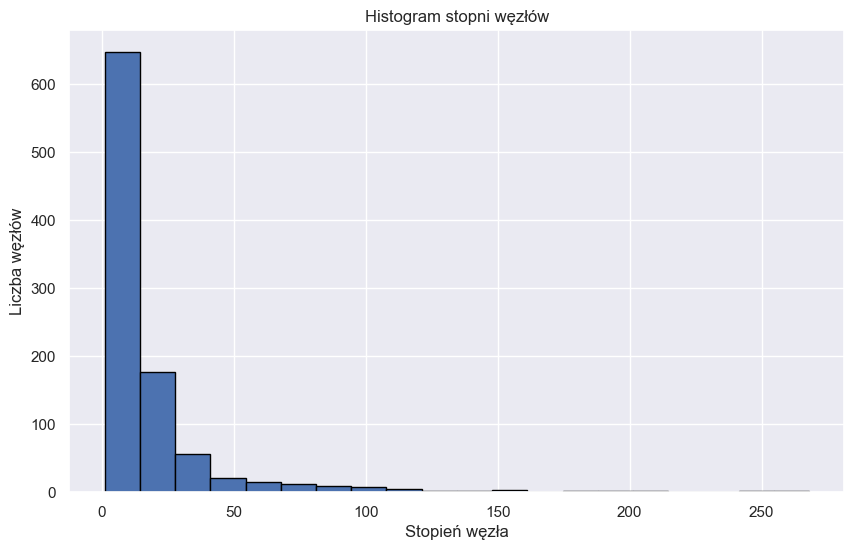

In [98]:
plt.figure(figsize=(10, 6))
plt.hist(degree_val, bins=20, edgecolor='black')
plt.title('Histogram stopni węzłów')
plt.xlabel('Stopień węzła')
plt.ylabel('Liczba węzłów')
plt.show()

**Wykrywanie najlepszych lokalizacji**

W połączonym grafie bliskość (closeness centrality) to średnia długość najkrótszej ścieżki między węzłem a wszystkimi innymi węzłami w grafie. Im bardziej centralny węzeł, tym znajduje się „bliżej” wszystkich innych węzłów.

In [99]:
closeness = nx.closeness_centrality(G)

best_closeness = sorted(closeness, key=closeness.get, reverse=True)[:20]

closeness_val = list(closeness.values())

print("10 przystanków o najwyższej centralności bliskości:")
for stop in best_closeness:
    print(f"{stop} - Centralność bliskości: {closeness[stop]}")

10 przystanków o najwyższej centralności bliskości:
Rynek - Centralność bliskości: 0.24889466840052016
GALERIA DOMINIKAŃSKA - Centralność bliskości: 0.24857142857142858
DWORZEC AUTOBUSOWY - Centralność bliskości: 0.2482490272373541
Arkady (Capitol) - Centralność bliskości: 0.24690402476780185
Hallera - Centralność bliskości: 0.24614197530864199
PL. JANA PAWŁA II - Centralność bliskości: 0.24532171238144065
Bałtycka - Centralność bliskości: 0.2441326530612245
Pomorska - Centralność bliskości: 0.24369747899159663
DWORZEC GŁÓWNY - Centralność bliskości: 0.2426470588235294
Bezpieczna - Centralność bliskości: 0.2426470588235294
Renoma - Centralność bliskości: 0.24215587044534412
Paprotna - Centralność bliskości: 0.24142280524722504
Rondo - Centralność bliskości: 0.24130105900151286
KROMERA - Centralność bliskości: 0.24069416498993965
PL. STASZICA - Centralność bliskości: 0.23984962406015037
Strzegomska (krzyżówka) - Centralność bliskości: 0.23930982745686422
FAT - Centralność bliskości: 0.2

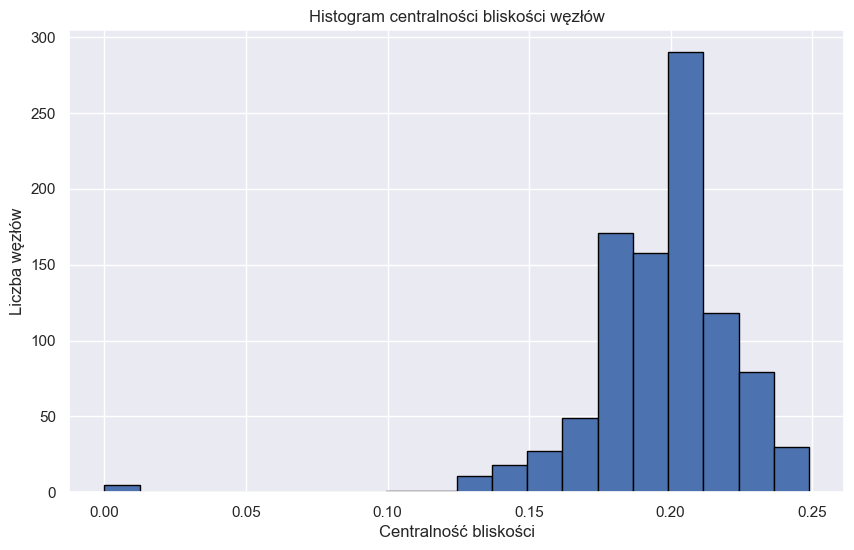

In [100]:
plt.figure(figsize=(10, 6))
plt.hist(closeness_val, bins=20, edgecolor='black')
plt.title('Histogram centralności bliskości węzłów')
plt.xlabel('Centralność bliskości')
plt.ylabel('Liczba węzłów')
plt.show()

**Współczynnik grupowania**

Współczynnik grupowania (Clustering coefficient) mówi nam jak dobrze połączone jest sąsiedztwo danego wierzchołka.

W kontekście sieci przystanków tramwajowych i autobusowych, współczynnik grupowania może pomóc zrozumieć, jak dobrze połączone są sąsiednie przystanki. Wysoki współczynnik grupowania oznacza, że sąsiednie wierzchołki mają tendencję do tworzenia gęstych połączeń, co sugeruje, że istnieją bezpośrednie lub krótkie połączenia między przystankami. Oznacza to, że wierzchołki w grafie, reprezentujące przystanki, tworzą spójne klastry, co może ułatwiać przesiadki pasażerom podróżującym między różnymi liniami lub środkami transportu.

In [101]:
clustering_coeff = nx.clustering(G)

clustering_values = list(clustering_coeff.values())

avg_clustering = nx.average_clustering(G)
print(f"Średni współczynnik grupowania dla całego grafu: {avg_clustering}")

Średni współczynnik grupowania dla całego grafu: 0.2898959037149812


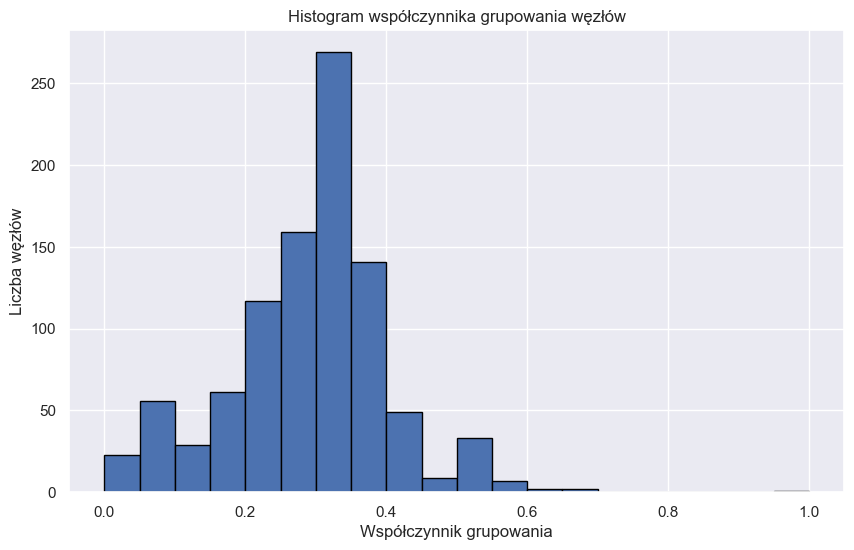

In [102]:

plt.figure(figsize=(10, 6))
plt.hist(clustering_values, bins=20, edgecolor='black')
plt.title('Histogram współczynnika grupowania węzłów')
plt.xlabel('Współczynnik grupowania')
plt.ylabel('Liczba węzłów')
plt.show()

**PageRank**

PageRank polega na liczeniu liczby i jakości linków do strony (węzła), aby określić przybliżoną ocenę ważności witryny (węzła). Podstawowym założeniem jest to, że im strona jest ważniejsza tym więcej odnośników na nią wskazuje.

In [105]:
pagerank_scores = nx.pagerank(G)

sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

top_10_pagerank = sorted_pagerank[:10]
print("Top 10 przystanków z najwyższym PageRankiem:")
for node, score in top_10_pagerank:
    print(f"Przystanek: {node}, PageRank: {score}")

Top 10 przystanków z najwyższym PageRankiem:
Przystanek: Bałtycka, PageRank: 0.003498066157197701
Przystanek: Kamieńskiego, PageRank: 0.003436899395260222
Przystanek: Hallera, PageRank: 0.0032246610200836368
Przystanek: C.H. Korona, PageRank: 0.0031234533794308544
Przystanek: Dubois, PageRank: 0.0030619448924370284
Przystanek: Pomorska, PageRank: 0.0029745719907488884
Przystanek: Broniewskiego, PageRank: 0.0029451609386800547
Przystanek: Arkady (Capitol), PageRank: 0.0028822921981701546
Przystanek: Dolnobrzeska, PageRank: 0.0028661481233929983
Przystanek: Rynek, PageRank: 0.0028400999618170275
